In [1]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ncxt_psftomo

### PSF correction in soft X-ray tomography
Ekman, Axel, et al. "PSF correction in soft X-ray tomography." _Journal of structural biology_ 204.1 (2018): 9-18. https://www.sciencedirect.com/science/article/pii/S1047847718301412

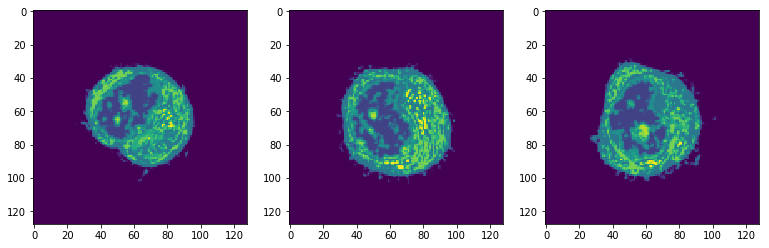

In [2]:
phantom = ncxt_psftomo.read_write_mrc.read_mrc('data/phantom.mrc')
ncxt_psftomo.plotters.volshow(phantom)

### Example PSF
- As an example, we here use a theoretical incoherent PSF (Born, Max, and Emil Wolf. _Principles of optics: electromagnetic theory of propagation, interference and diffraction of light._) 

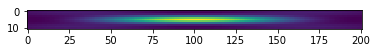

In [3]:
resolution = 4
dof = 50
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,5,101)
plt.imshow(ncxt_psftomo.psf_utils.psf_slice(resolution,dof,5,201))

### Dimenstions
- The data format is 
    - volume: (horizontal x,horizontal y,vertical)
    - projections: (angles, horizontal, vertical)
    - PSF: (axial, horizontal, vertical)

In [4]:
angles = np.linspace(0,np.pi,90,endpoint = False)
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
projections_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
ncxt_psftomo.forward(phantom, projections, psf, angles)
ncxt_psftomo.forward_bl(phantom, projections_bl, angles)

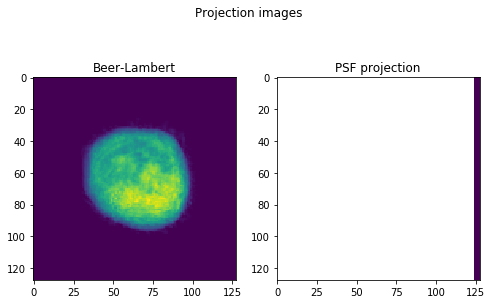

In [5]:
f,(ax1,ax2)= plt.subplots(ncols=2,figsize=(8,5))
ax1.imshow(projections_bl[0].transpose())
ax2.imshow(projections[0].transpose())
plt.suptitle("Projection images")
ax1.set_title("Beer-Lambert")
_ = ax2.set_title("PSF projection")

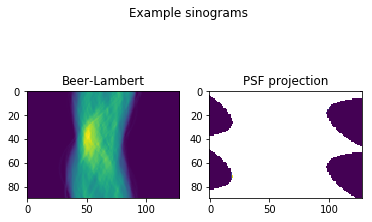

In [6]:
vertical_index = 40
f,(ax1,ax2)= plt.subplots(ncols=2)
ax1.imshow(projections_bl[:,:,vertical_index])
ax2.imshow(projections[:,:,vertical_index])
plt.suptitle("Example sinograms")
ax1.set_title("Beer-Lambert")
_ = ax2.set_title("PSF projection")

### Example reconstruction using CGLS

In [7]:
def CG_BL(x, y, angles, n_iter):
    _y = np.zeros(y.shape)
    _r = np.zeros(y.shape)
    _q = np.zeros(y.shape)
    _s = np.zeros(x.shape)

    ncxt_psftomo.forward_bl(x, _y, angles)
    _r = y - _y
    ncxt_psftomo.backward_bl(_s, _r, angles)
    gamma0 = np.sum(_s * _s)
    _p = _s

    for i in range(n_iter):
        ncxt_psftomo.forward_bl(_p, _q,angles)
        alpha = gamma0 / np.sum(_q * _q)
        x += alpha * _p
        _r -= alpha * _q

        ncxt_psftomo.backward_bl(_s, _r, angles)
        gamma = np.sum(_s * _s)
        beta = gamma / gamma0
        gamma0 = gamma       
        _p = _s + beta * _p        
        print(f'Iter {i} alpha {alpha} resnorm {np.sqrt(np.sum(_r*_r))}')
    return x

### Ideal projections

In [8]:
na, nx, ny = projections.shape
rec_test = np.zeros((nx, nx, ny))
rec_test = CG_BL(rec_test, projections_bl, angles, 10)
ncxtutils.volshow(rec_test)

Iter 0 alpha 0.00010097085889184349 resnorm 496605.94068392896
Iter 1 alpha 0.00022500593037761294 resnorm 266408.4593944668
Iter 2 alpha 0.0001361682695112143 resnorm 138767.44571415256
Iter 3 alpha 0.0005441285736720948 resnorm 85240.5660067306
Iter 4 alpha 0.00022291062702818265 resnorm 65686.98939421408
Iter 5 alpha 0.00019823841765279014 resnorm 50232.374056261884
Iter 6 alpha 0.0006439443120220142 resnorm 35274.48386094648
Iter 7 alpha 0.0002471639952676626 resnorm 31452.976868018577
Iter 8 alpha 0.0002873850770028881 resnorm 25680.96085470806
Iter 9 alpha 0.000774782018311068 resnorm 19995.819213953655


NameError: name 'ncxtutils' is not defined

### PSF limited projections

In [ ]:
na, nx, ny = projections.shape
rec_bl = np.zeros((nx, nx, ny))
rec_bl = CG_BL(rec_bl, projections, angles, 10)
ncxtutils.volshow(rec_bl)